In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from preprocess_functions import preprocess #preprocess is a class containing all the function
#May have to specify the location of the preprocess_functions files relative to this one

## Finding the right files
First it can be useful to locate and save the path to several fluorescence files at once, but One can also just do it one by one. But for now, here's a way to use os.walk to get several files at once.

Generally the folder structure needs to be reconsidered and decided upon.

In [2]:
path = '/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2718/2024_12_05-12_55_41'
save_to_path = path #path to which you want the data to ba saved. Can be the same as the rootdir

if os.path.isdir(path):
    print("Path exists and it's a directory.")
else:
    print("Path does not exist.")

Path exists and it's a directory.


## Applying the relevant preprocessing functions
Have a look at the printed text. Ensure that the mouse ID is correct. If you have a different way of naming the files and, the code will need to be adjusted. 

For now, it uses the folder name to get the mouse ID and the experiment name.

It asks for the sex of the animal and the location of the fiber. I usually write M or F for the sex, and V2M or V1 for the location. Whatever you do name it, it's best to be consistent to make the data analysis better. 

First, lets do it one by one.

In [3]:
# selecting a sensor. For now, the functions respond to 'G8m', 'g5-HT3', 'rG1' or asks for user input for half decay time in ms.
sensors = {'470':'g5-HT3', '560':'rG1', '410':'g5-HT3'}

'''
Now create an object which will contain an increasing amount of information as functions are called on
Now it is just an object with a self containing the sensor name and the path and some colors for plotting
'''
processed_1 = preprocess(path, sensors)
# extract all relevant and irrelevant info from the Fluorescence.csv file which contains the metadata 
processed_1.Info = processed_1.get_info()

In [4]:
print (processed_1.path.split('/'))
# testing for Cohort1
print ("recording time:", processed_1.path.split('/')[-2][:]) # recording time
print ("animal ID:", processed_1.path.split('/')[-3])#[:6]) #animal ID
print ("experiments:", processed_1.path.split('/')[-4][:]) #experiments
print ("session (seems unused):", processed_1.path.split('/')[-3][5:]) # session
#WE HAVE a problem here with session BUT I don't think it is used anyway 

['', 'Users', 'rancze', 'Documents', 'Data', 'vestVR', 'Cohort1', 'photometry', 'Cohort1_visual_mismatch_day1', 'B6J2718', '2024_12_05-12_55_41', '']
recording time: 2024_12_05-12_55_41
animal ID: B6J2718
experiments: Cohort1_visual_mismatch_day1
session (seems unused): 18


Now I recommend going to line 134 in the function script and look for the line: 
- mousename = self.path.split('/')[-3]#[:6]

CHECK all split functions around here, as they may be different depending on the folder structure 


the file structure should be so that self.path.split('/')[-3] will give a string with the name of the mouse. However, sometimes the name is saved in a string for example like this: 
- 'B6J2723-2024-12-05T15-57-58'

If so, please add [:4]where the number is the same as the number of letters that the name consist of. The slicing my have to be different if the name for example comes at the end

OR: rename the filenames to include just the mouse Id and not the date or anything else

In [5]:
processed_1.rawdata, processed_1.data, processed_1.data_seconds, processed_1.signals, processed_1.save_path = processed_1.create_basic(path_save = save_to_path, cutstart = False)
'''
Here, we run the create_basic() function. This involves saving some data for later. 
- The first element is the raw-data, just meaning that it is just saved to the object
- The second element gives the cut data if cutstart = TRUE, now cutting the first 15 seconds due to initial bleaching 
- The third element is just the timestamps made into seconds (rather than milliseconds)
- The fourth elements is a df of flourescent traces only from each of the recorded exitatory wavelenghts
- Fith element is the path created in which the preprocessed file and plots will be saved. 
    This part assumes the presence of a folder in the same location as this file named 'preprocessed' where all preprocessed data can be saved
    If it does not exist already, there is created folders 
    named by the encloding experiment folder, the animal folder, and the time and date folder.
    If it already exists - whatch out, whatever is stored there will be overwritten if it has the same names 
        - for example if you already preprocessed it
    For now, this is an empty folder
'''
print('\nFolder created or already exsisting:\n', processed_1.save_path)



  Preprocessing data for B6J2718 at 2024_12_05-12_55_41 ... 

Adding event bools
'photometry_processed' directory already exists at: /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2718/2024_12_05-12_55_41/photometry_processed
Directory for mouse 'B6J2718' already exists at: /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2718/2024_12_05-12_55_41/photometry_processed/B6J2718
Final save path: /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2718/2024_12_05-12_55_41/photometry_processed/B6J2718

Folder created or already exsisting:
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2718/2024_12_05-12_55_41/photometry_processed/B6J2718


In [6]:
processed_1.data.loc[processed_1.data.Input1_event == False]
#processed_1.data.loc[processed_1.data.State == 0] #If there is an Input1_event it should be False when state is NaN or 1

,TimeStamp,470,410,560,Event,State,Input1_event
0,11.111,125.927,23.897,107.949,NaN,NaN,False
1,44.443,126.163,23.897,107.949,NaN,NaN,False
2,77.771,125.892,23.920,108.208,NaN,NaN,False
3,111.109,125.950,23.847,108.146,NaN,NaN,False
4,144.443,126.004,23.894,108.520,NaN,NaN,False
...,...,...,...,...,...,...,...
76097,2536236.579,122.077,20.739,96.341,Input1,1.0,False
76098,2536269.903,122.151,20.753,96.302,Input1,1.0,False
76099,2536303.231,121.450,20.746,96.485,Input1,1.0,False
76100,2536336.561,122.389,20.750,96.332,Input1,1.0,False


In [7]:
processed_1.events = processed_1.extract_events()
'''
now we have an element 'events' containing timestamped events
for each event there will be a _starts and a _stops and a _event
 _starts: numpy nans for all rows except at the time stamp where the event starts
 _stops: numpy nans for all rows except at the time stamp where the event stops
 _events: False whenever the event did not take place, and True while it did take place
 The event is named the same as was as it was recorded
'''
#processed_1.events

"\nnow we have an element 'events' containing timestamped events\nfor each event there will be a _starts and a _stops and a _event\n _starts: numpy nans for all rows except at the time stamp where the event starts\n _stops: numpy nans for all rows except at the time stamp where the event stops\n _events: False whenever the event did not take place, and True while it did take place\n The event is named the same as was as it was recorded\n"

### Filtering
Now, by running and saving the low_pass_filt() function, all the sigals are low pass filtered using a butterworth filter. This  is where the sensor comes in, as it decides the critical frequency used, which needs to be adapted to the decay time of the sensor.
The plot that is made is of the raw trace and the filtered trace, and is also saved to the folder created above, where is can be looked at in more detail. 

Filtering 470 with sensor g5-HT3 at 5 Hz
Filtering 560 with sensor rG1 at 10 Hz
Filtering 410 with sensor g5-HT3 at 5 Hz


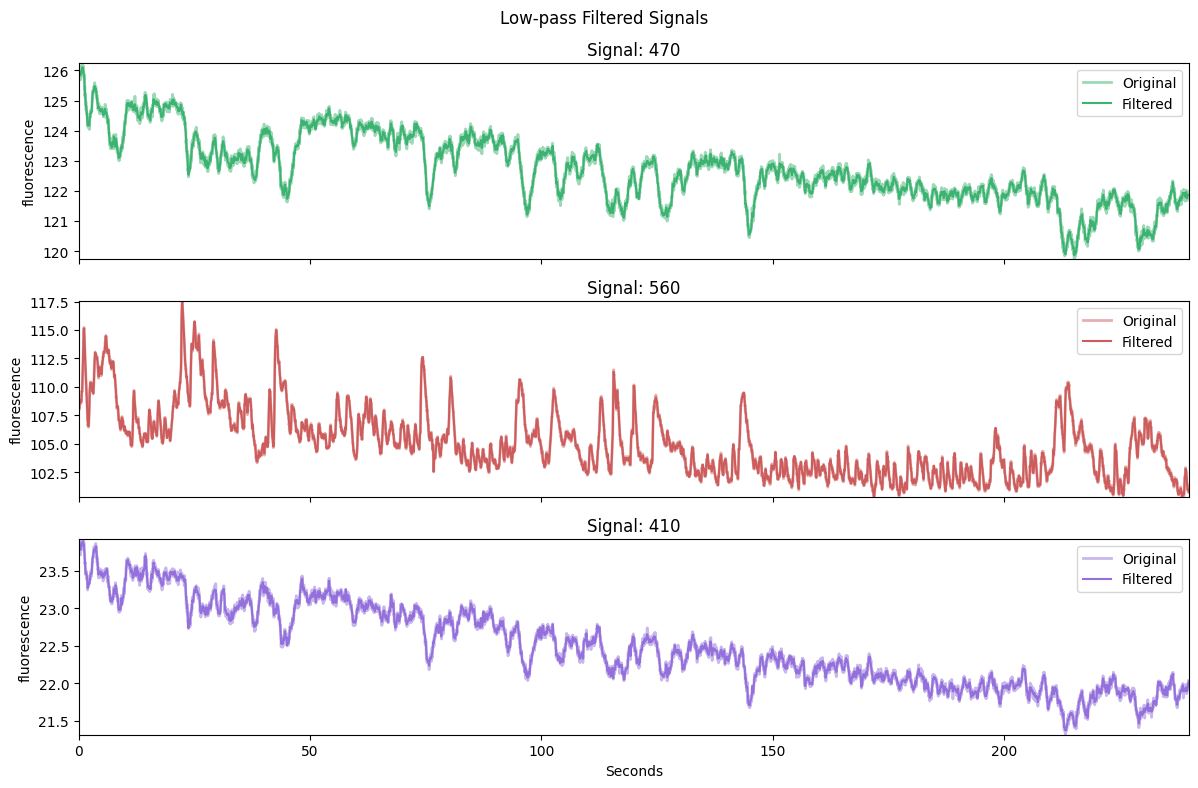

Filtering 470 with sensor g5-HT3 at 5 Hz
Filtering 560 with sensor rG1 at 10 Hz
Filtering 410 with sensor g5-HT3 at 5 Hz


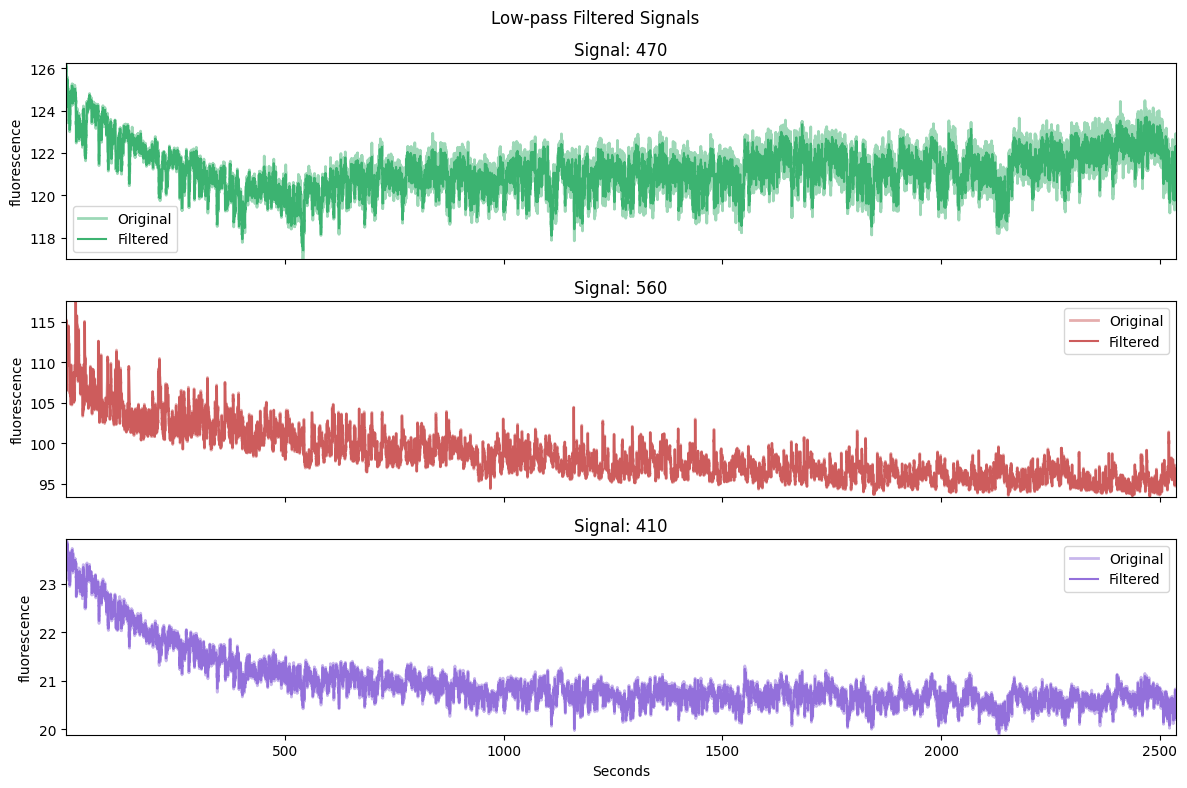

In [8]:
processed_1.filtered = processed_1.low_pass_filt(plot=True, x_start=0, x_end=240)
processed_1.filtered = processed_1.low_pass_filt(plot=True)

### Detrending
A double exponential fit is made to account for sources of bleaching and the signal is corrected.

method = "subtractive" assumes bleaching is sensor-independent (e.g. autofluorescence) and this is then subtracted from the flourescence treaces to get a detreded signal.

method = "divisive" assumes bleaching comes from the sensor. This is most plausible. 
N.B. detrended data is already dF/F. 

Parameters used for detrending filtered_470:  [1.21010465e+02 4.21873206e+00 7.00045413e-24 2.03932979e+04
 4.92756916e-03]
Parameters used for detrending filtered_560:  [9.44774448e+01 5.75940312e+00 1.01882656e+01 1.05374314e+03
 6.05729543e-02]
Parameters used for detrending filtered_410:  [2.05554882e+01 2.25823638e+00 7.38551773e-01 8.31353153e+02
 2.36656417e-01]


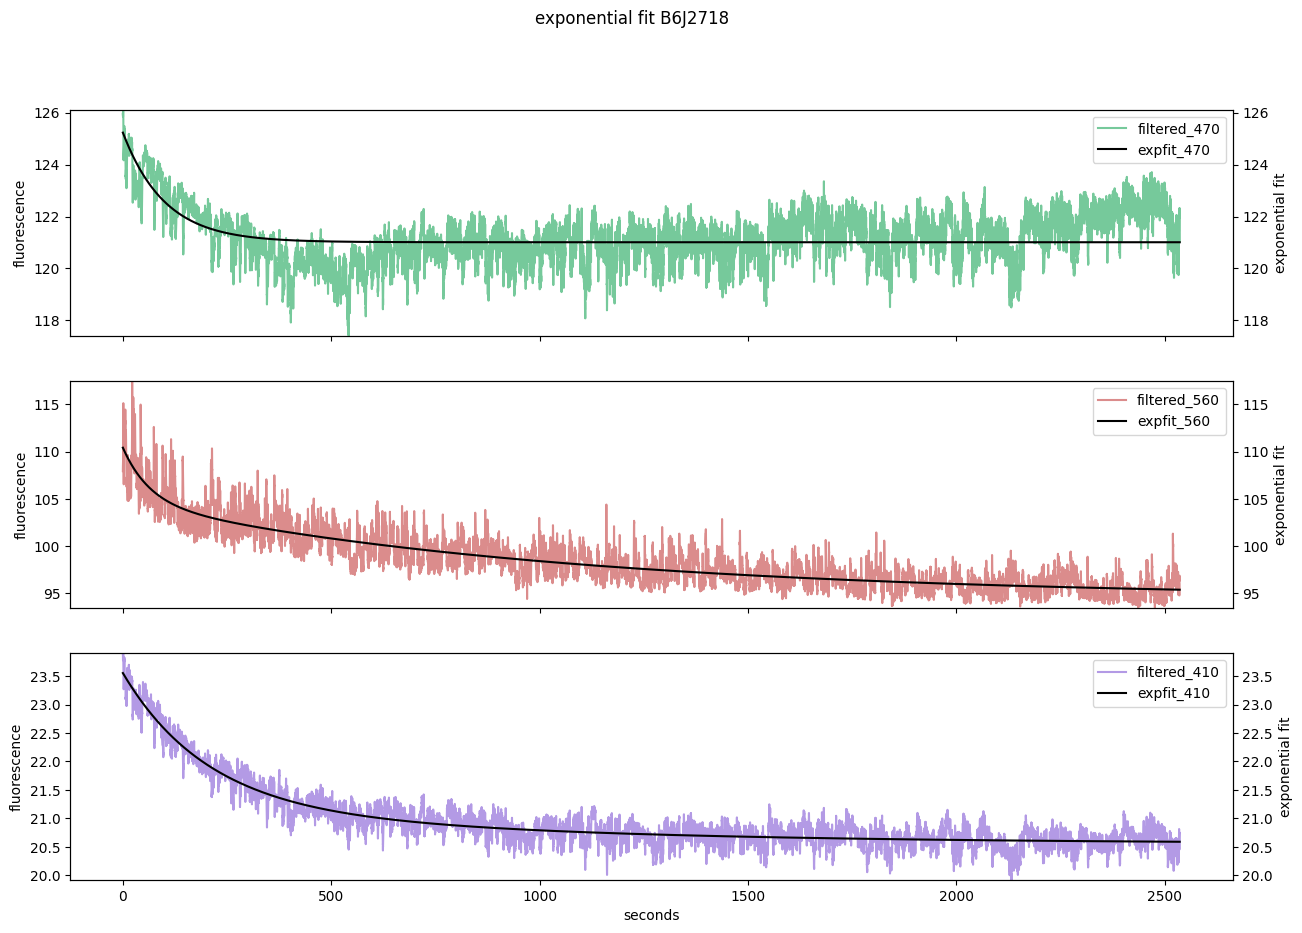

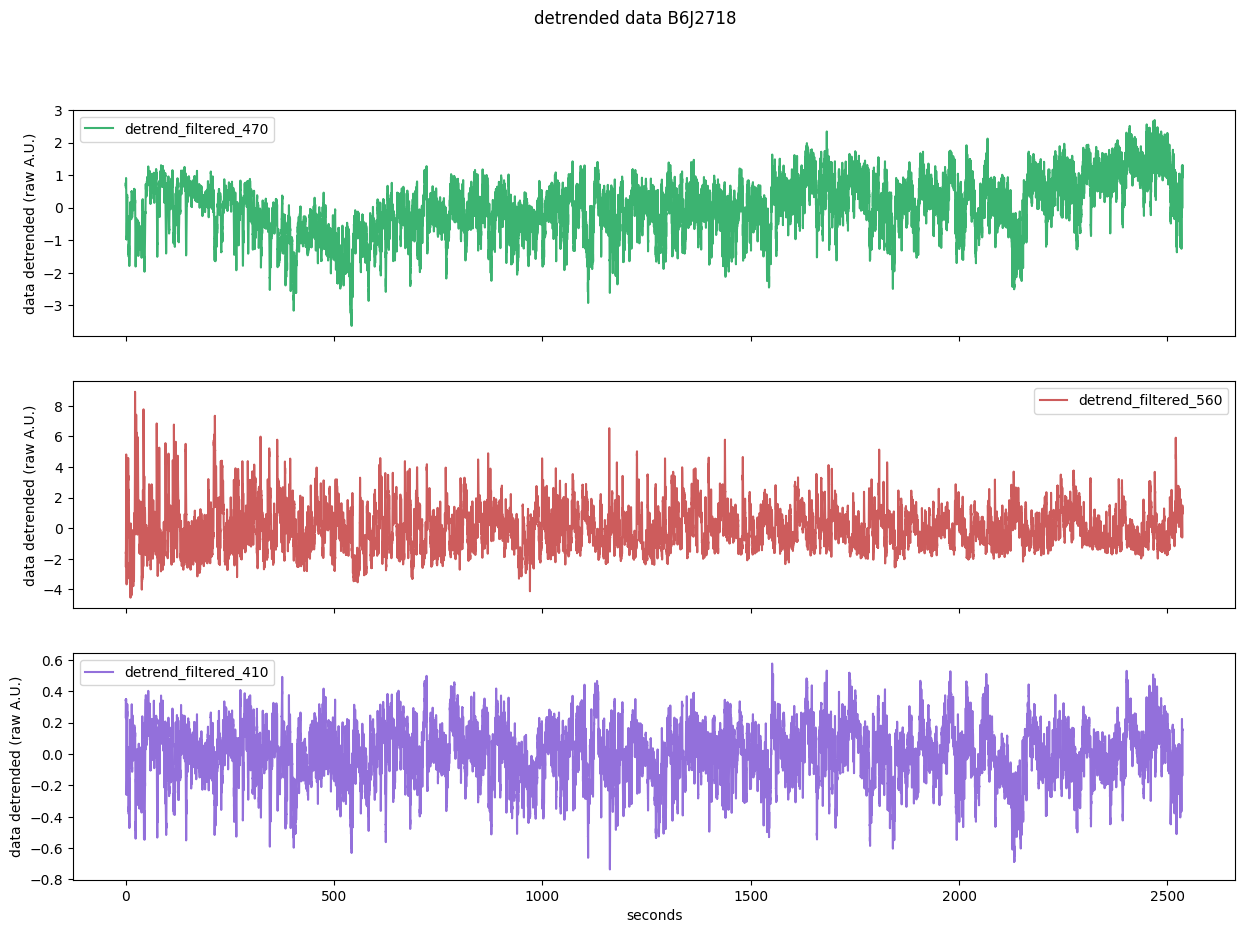

In [10]:
processed_1.data_detrended, processed_1.exp_fits = processed_1.detrend(plot = True, method = "subtractive")

### Motion correction
There is a motion correction function that can be used. It is now set to use the 560 nm signal, because of my doubts with the relevans of the 410 nm signal as isosbestic trace. For now, I recommend not running this one.

The slope of the linear regression between the main signal and the control is:  3.4209085731197124
Slope    : 3.421
R-squared: 0.530


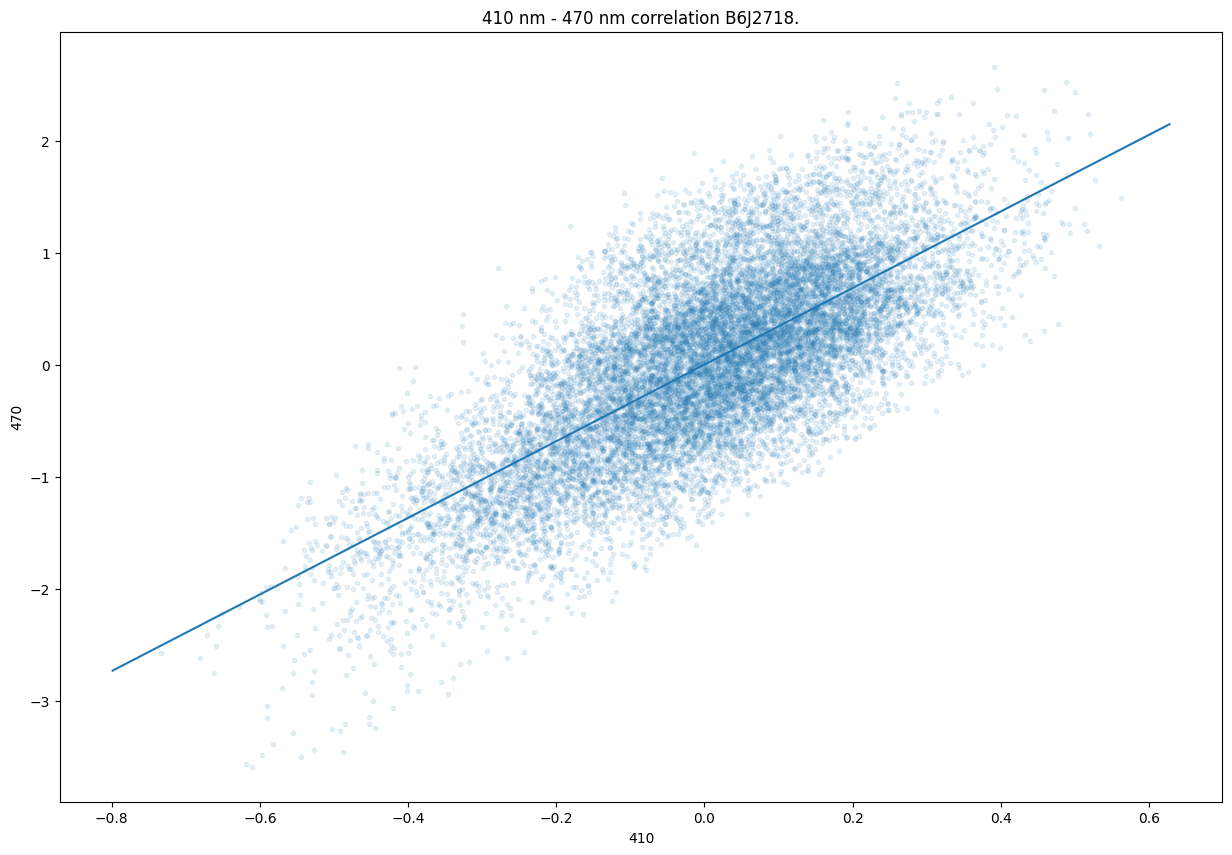

In [11]:
processed_1.motion_corr = processed_1.movement_correct(plot = True)

### Z-scoring
Takes the median and standard deviation of the trace. Then subtracts the median from all datapoints and divides by the standard deviation. If motion correction has been run, then it does so with the motion corrected traces, if motion is set to False. Actually, it is defaulth set to False, so its not necessary, but it can also be set to True, to have a look at how it would be with the motion correction.

/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:595: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


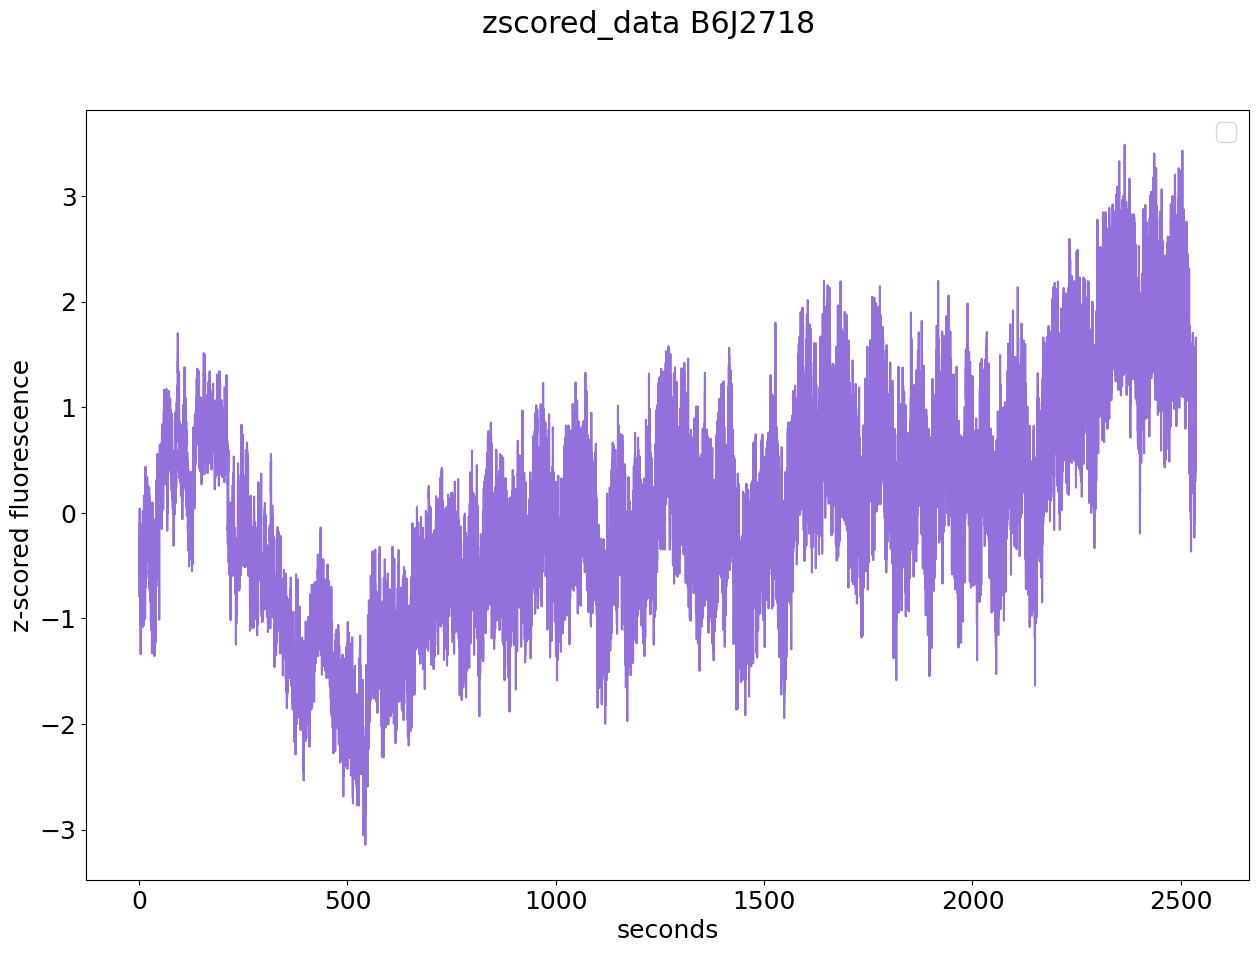

In [12]:
processed_1.zscored = processed_1.z_score(motion = True, plot = True)

### Delta F / F

WITH divisive detrending, this is not needed

This is a standard way of calculating the detla F over F signal, i.e. the % change in signal. I do think it is a bit weird to use the detrending exponential fit again. I have wondered if I should change it to just a linear fit to the current detrended signal. For now I do this based on the fiber photometry primer paper code: https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb

Again, 'motion' can be set to True, bu tis defaulth False


The method used for detrending was subtractive, deltaF/F is calculated now.


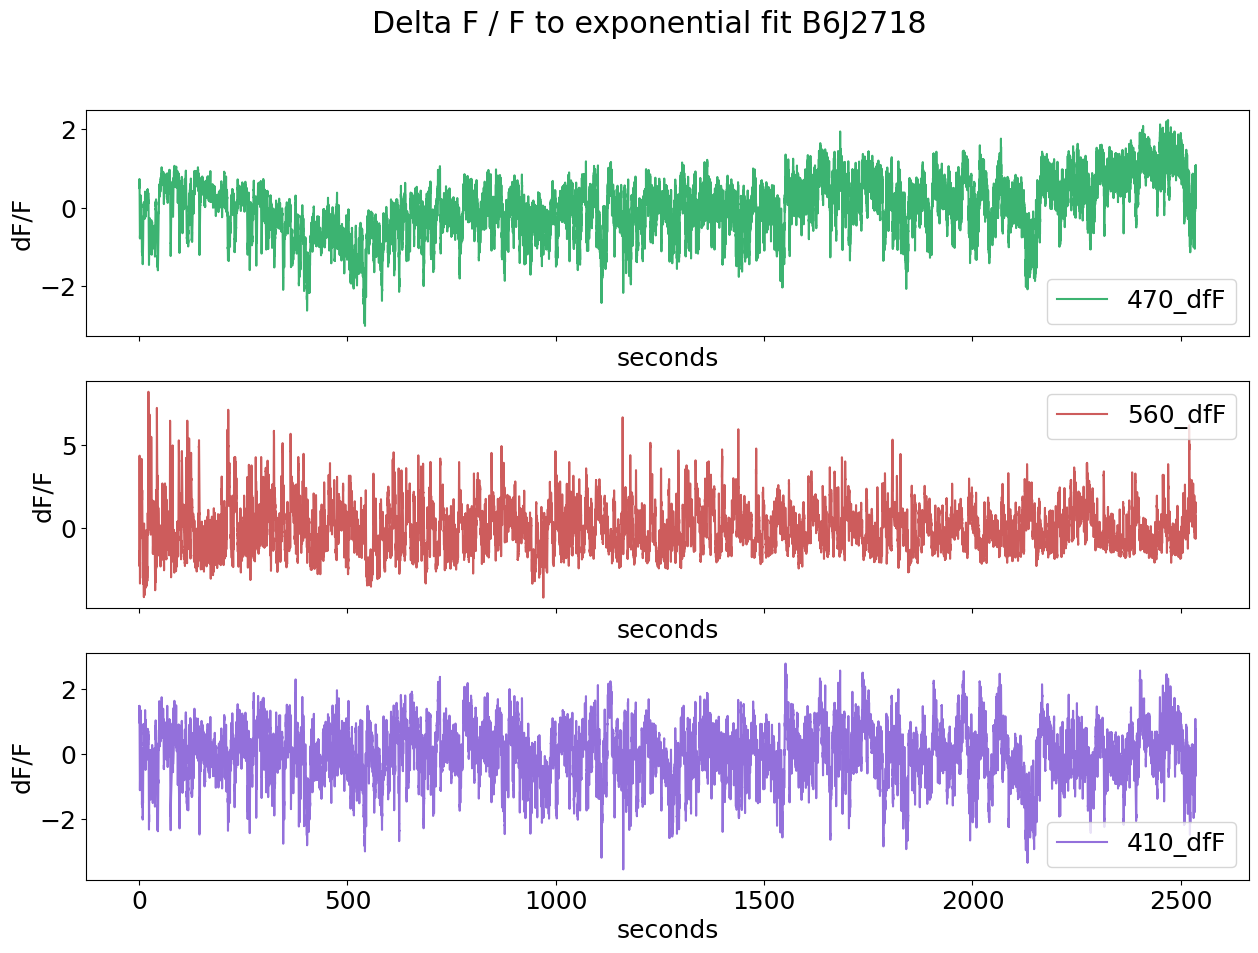

In [13]:
processed_1.deltaF_F = processed_1.get_deltaF_F(motion = False, plot = True)

### Add crucial info
Here, some crucial info is added that will be included in the output csv file in the end. 
This includes the mouse ID, which is currently automatically taken from the folder name. However, if the folder is not named in this way, the function will need adjustment to account for some other way of getting the mouse ID.
The function will ask you to provide the following:
-  Location of fluorescent protein: write something simple and consistent across different recordings, like V1 and V2M
-  Sex of the animal (cause that could be relevant): easiest to just write F or M

In [41]:
processed_1.crucial_info = processed_1.add_crucial_info()

Please ensure that B6J2718 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B6J2718
Add the location of fluorescent protein: rGeco1
Add the sex of the mouse: X
info added for B6J2718



In [42]:
processed_1.Info

{'Light': {'Led410Enable': True,
  'Led470Enable': True,
  'Led560Enable': True,
  'Led410Value': 2.0,
  'Led470Value': 5.999999999999995,
  'Led560Value': 55.0},
 'Excitation': {'mode': 3,
  'discontinuous': False,
  'interval_time': 20,
  'continuous_time': 20},
 'Channels': [{'Name': 'CH1',
   'Roi1': '271.833802816901,213.670422535211,147.419718309859,147.419718309859',
   'Roi2': '271.321126760564,211.107042253521,147.419718309859,147.419718309859'}],
 'AllMarking': [{'id': 0,
   'type': 1,
   'opened': True,
   'name': 'move',
   'Levels': 0,
   'color': '#FFFFC000',
   'key': 0,
   'threshold': 0.0,
   'all': True,
   'channels': ['AllChannel', 'CH1'],
   'enable': True},
  {'id': 0,
   'type': 1,
   'opened': True,
   'name': 'y',
   'Levels': 0,
   'color': '#FF9BBB59',
   'key': 0,
   'threshold': 0.0,
   'all': True,
   'channels': ['AllChannel', 'CH1'],
   'enable': True},
  {'id': 0,
   'type': 2,
   'opened': True,
   'name': 'Input1',
   'Levels': 0,
   'color': '#FF0099

### Save it as a .csv files
This function will lead to it all being saved as a csv file which can easily be read as a pandas dataframe when the data is to be analysed.
First it is the info csv, which I for now save, but never actually use...
Then it is the main csv file which is very useful indeed. For this one you can add Events = True to also save the events, and motion_correct = True if you have doen motion correction and want to use this.The only difference for the latter, is really that it also saved the motion corrected raw signal. Regardless, if you did use motion correction for deltaF and z-score, this is the version that will be saved

In [43]:
#again it ensures that the folder to save in already exists, since the csv must have somewhere to be
processed_1.info_csv = processed_1.write_info_csv()
processed_1.data_csv = processed_1.write_preprocessed_csv()
#optional:, motion_correct = True, Onix_align =False

Processed_fluorescence.csv file saved to  /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2718/2024_12_05-12_55_41/photometry_processed/B6J2718
Saving original Events.csv to Events.csv to be used for ONIX alingment


### Have a look
By importing pandas, you can now read the file, by compying the path from above and adding 'preprocessed.csv' which is the name of your new file. Sorry about the unnamed file. It can be removed. I'll do that

In [21]:
import pandas as pd
pd.read_csv(save_to_path+'/'+processed_1.mousename+'/photometry_processed/Events.csv')

,TimeStamp,Name,State
0,8503.373,Input1,0
1,11779.907,Input1,1
2,14768.140,Input1,0
3,19130.836,Input1,1
4,21623.849,Input1,0
...,...,...,...
629,1885525.856,Input1,1
630,1888434.112,Input1,0
631,1892430.317,Input1,1
632,1895625.423,Input1,0


In [22]:
pd.read_csv(save_to_path+'/'+processed_1.mousename+'/photometry_processed/Processed_fluorescence.csv')

,TimeStamp,filtered_470,filtered_560,filtered_410,470_dfF,560_dfF,410_dfF,z_470,z_560,z_410,Time,mouseID,Area,Sex
0,15.011110,60.750,9.094,13.336148,-3.401339,-0.118409,4.800172,-1.124964,-0.467691,4.059622,2024-08-08 12:08:44.011110,B3M3,V1,M
1,15.044442,64.074,9.135,13.238875,1.884158,0.332182,4.035766,0.947863,1.160722,3.405835,2024-08-08 12:08:44.044442,B3M3,V1,M
2,15.077776,68.062,9.120,13.146754,8.225483,0.167712,3.311848,3.434756,0.566333,2.786679,2024-08-08 12:08:44.077776,B3M3,V1,M
3,15.111110,69.676,9.104,13.067576,10.791906,-0.007743,2.689640,4.441237,-0.067749,2.254514,2024-08-08 12:08:44.111110,B3M3,V1,M
4,15.144442,69.759,9.099,13.008761,10.923885,-0.062382,2.227452,4.492995,-0.265210,1.859211,2024-08-08 12:08:44.144442,B3M3,V1,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56863,1910.191877,63.243,8.760,12.889807,0.562784,-1.392686,1.292666,0.429656,-4.950664,1.059701,2024-08-08 12:40:19.191877,B3M3,V1,M
56864,1910.225208,63.311,8.817,12.900128,0.670911,-0.751044,1.373770,0.472061,-2.688100,1.129068,2024-08-08 12:40:19.225208,B3M3,V1,M
56865,1910.258534,62.999,8.777,12.915368,0.174799,-1.201286,1.493536,0.277499,-4.275746,1.231503,2024-08-08 12:40:19.258534,B3M3,V1,M
56866,1910.291861,62.518,8.807,12.934425,-0.590040,-0.863570,1.643294,-0.022449,-3.084890,1.359588,2024-08-08 12:40:19.291861,B3M3,V1,M


### Mass production
When several paths are saved in one list, we can just loop through the list and create all the files. It is  a good idea to have a look at all the saved plots anyways. Also, for now you must wait for the prompts to add the crucial info. If you prefer I can change it so that you can add that some other way, but I like this way so I can be certain that I get it right. 

In [23]:
import matplotlib.pyplot as plt
from preprocess_functions import preprocess #preprocess is a class containing all the function, not sure why I made it a class
#May have to specify the location of the preprocess_functions files relative to this one
import numpy as np
import os

In [24]:
import os
paths = []
rootdir = '/Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1'
for root, dirs, files in os.walk(rootdir):
    for filename in files:
        if filename == 'Fluorescence-unaligned.csv':
            #if 'wakeup' in root:
            paths.append(root)
[print(path) for path in paths]

path_save = rootdir 

/Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/photometry/B6J2717/2024_12_05-11_54_18
/Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/photometry/B6J2723/2024_12_05-17_01_15


Now loop through the list of paths and 

In [25]:
rootdir 

'/Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1'

In [27]:
for path in paths: 
    sensors = {'470':'g5-HT3', '560':'G8m', '410':'g5-HT3'}
    processed = preprocess(path, sensors)
    processed.Info = processed.get_info()
    processed.rawdata, processed.data, processed.data_seconds, processed.signals, processed.save_path = processed.create_basic(path_save = path_save)
    processed.events = processed.extract_events()
    processed.filtered = processed.low_pass_filt()
    processed.data_detrended, processed.exp_fits = processed.detrend()
    processed.motion_corr = processed.movement_correct()
    processed.zscored = processed.z_score(motion = False)
    processed.deltaF_F = processed.get_deltaF_F(motion = False)
    processed.crucial_info = processed.add_crucial_info()

    processed.info_csv = processed.write_info_csv()

    processed.data_csv = processed.write_preprocessed_csv()#Events = True) #optional: Events = True, motion_correct = True




  Preprocessing data for B6J2717 at 2024_12_05-11_54_18 ... 

Adding event bools
'photometry_processed' directory already exists at: /Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2717/photometry_processed
Final save path: /Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2717/photometry_processed
recording frame rate per wavelength:  30.0
Filtering 470 with sensor g5-HT3
Filtering of 470 completed. Time taken: 0.0019278526306152344
Filtering 560 with sensor G8m
Wn is set to 25 for the sensor G8m, while the frame rate is set to 30.0 fps
Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=30.0 -> fs/2=15.0)
The signal 560 is not filtered and will be returned as-is.
Filtering 410 with sensor g5-HT3
Filtering of 410 completed. Time taken: 0.0037779808044433594
Parameters used for detrending filtered_470:  [4.19788886e+01 1.79394141e+00 3.59309478e-20 3.19482315e+04
 1.05685779e-02]
Parameters used for detrending filtered_560:  [8.50412064e+01 1.9

Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  M


info added for B6J2717

Processed_fluorescence.csv file saved to  /Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2717/photometry_processed
Saving original Events.csv to Events.csv to be used for ONIX alingment


  Preprocessing data for B6J2723 at 2024_12_05-17_01_15 ... 

Adding event bools
'photometry_processed' directory already exists at: /Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2723/photometry_processed
Final save path: /Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2723/photometry_processed
recording frame rate per wavelength:  30.0
Filtering 470 with sensor g5-HT3
Filtering of 470 completed. Time taken: 0.0019237995147705078
Filtering 560 with sensor G8m
Wn is set to 25 for the sensor G8m, while the frame rate is set to 30.0 fps
Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=30.0 -> fs/2=15.0)
The signal 560 is not filtered and will be returned as-is.
Filtering 410 with sensor g5-HT3
Filtering of 410 complet

Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  M


info added for B6J2723

Processed_fluorescence.csv file saved to  /Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2723/photometry_processed
Saving original Events.csv to Events.csv to be used for ONIX alingment
